In [1]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torchaudio.transforms as T
import torchvision
import torch.optim as optim
import scipy as sp
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datetime

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [2]:
root_dir = os.path.join('/data', 'EPIC-KITCHENS')
annotations_dir = os.path.join('..', 'data', 'annotations')
train = True
filename = 'EPIC_100_train_clean.pkl'

In [3]:
def load_data(filename):
    '''
    Load the WAV file and its label.
    Args :
        • filename: str. The path of a WAV file.
    Returns A tuple of two Pandas DataFrame objects:
        • signals: A DataFrame with the following columns:
            • seconds: The time in seconds.
            • AcclX: The acceleration along the x-axis.
            • AcclY: The acceleration along the y-axis.
            • AcclZ: The acceleration along the z-axis.
            • GyroX: The angular velocity along the x-axis.
            • GyroY: The angular velocity along the y-axis.
            • GyroZ: The angular velocity along the z-axis.
        • sampling_rate: The sampling rate of the WAV file.
    '''
    # TODO: Load the WAV file and its label
    df_accl, df_gyro = pd.read_csv(filename + '-accl.csv'), pd.read_csv(filename + '-gyro.csv')
    # seconds = df_accl['Milliseconds'] / 1000.0
    seconds = df_accl['Milliseconds']
    seconds.name = "seconds"
    sampling_rate = int(len(df_accl) / (seconds.iloc[-1] - seconds.iloc[0]))
    seconds = torch.tensor(seconds.values, dtype=torch.float32)
    accl, gyro = df_accl[["AcclX", "AcclY", "AcclZ"]], df_gyro[["GyroX", "GyroY", "GyroZ"]]
    accl = torch.tensor(
        np.array([
            accl['AcclX'].to_numpy(),
            accl['AcclY'].to_numpy(),
            accl['AcclZ'].to_numpy()
        ]), dtype=torch.float32)
    gyro = torch.tensor(
        np.array([
            gyro['GyroX'].to_numpy(),
            gyro['GyroY'].to_numpy(),
            gyro['GyroZ'].to_numpy()
        ]), dtype=torch.float32)
    return seconds, (accl, gyro), sampling_rate

In [4]:
def trim_data(data, downsampling_rate, ws=3):
    '''
    Trim the data to a fixed window size.
    Args:
        • data: A tuple of two torch.Tensor objects. The first tensor is the milliseconds data and the second tensor is the acceleration data.
        • downsampling_rate: int. The desired downsampling rate.
        • ws: int. The window size in seconds.
    Returns:
        • accl: The acceleration data with shape (3, ws * downsampling_rate).
        • downsampling_rate: The new downsampling rate.

    '''
    milliseconds, amplitudes = data
    ws_extended = ws * downsampling_rate
    start = 0
    end = ws_extended
    
    

In [5]:
df = pd.read_pickle(os.path.join(annotations_dir, filename))
df = df.dropna()
df = df.reset_index(drop=True)
df

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01,P01_102,00:00:01.100,00:00:00.54,00:00:02.23,27,111,take knife and plate,take,0,knife,4,"[knife, plate]","[4, 2]"
1,P01,P01_102,00:00:07.600,00:00:07.49,00:00:09.05,374,452,move spatula and colander,move,11,spatula,20,"[spatula, colander]","[20, 39]"
2,P01,P01_102,00:00:29.851,00:00:29.66,00:00:30.84,1483,1542,take knife,take,0,knife,4,[knife],[4]
3,P01,P01_102,00:03:44.600,00:03:44.45,00:03:45.00,11222,11250,wipe surface,wipe,2,surface,42,[surface],[42]
4,P01,P01_102,00:03:45.600,00:03:45.61,00:03:46.01,11280,11300,move glass,move,11,glass,10,[glass],[10]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37450,P37,P37_103,00:06:16.903,00:06:17.17,00:06:17.67,18858,18883,turn off tap,turn-off,8,tap,0,[tap],[0]
37451,P37,P37_103,00:06:22.154,00:06:17.86,00:06:23.77,18893,19188,take pan,take,0,pan,5,[pan],[5]
37452,P37,P37_103,00:06:26.404,00:06:23.45,00:06:32.66,19172,19633,pour out boiled water,pour-out,9,water:boiled,27,[water:boiled],[27]
37453,P37,P37_103,00:00:41.151,00:00:40.57,00:00:44.19,2028,2209,debone chicken thighs,debone,30,thigh:chicken,57,[thigh:chicken],[57]


In [6]:
line = df.iloc[0, :]
start = pd.Timestamp(line['start_timestamp'])
stop = pd.Timestamp(line['stop_timestamp'])

stop - start

Timedelta('0 days 00:00:01.690000')

### Controllo sulla durata
Controllo fatto per vedere se l'ultimo stop_timestamp combacia con l'effettiva durata dei timestamp nel file dell'accelerometro.

In [7]:
df.where(df['video_id'] == 'P01_102').sort_values(by='start_timestamp').dropna()

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01,P01_102,00:00:01.100,00:00:00.54,00:00:02.23,27.0,111.0,take knife and plate,take,0.0,knife,4.0,"[knife, plate]","[4, 2]"
1,P01,P01_102,00:00:07.600,00:00:07.49,00:00:09.05,374.0,452.0,move spatula and colander,move,11.0,spatula,20.0,"[spatula, colander]","[20, 39]"
39,P01,P01_102,00:00:10.350,00:00:09.66,00:00:10.84,483.0,542.0,open bin,open,3.0,bin,36.0,[bin],[36]
50,P01,P01_102,00:00:11.600,00:00:11.09,00:00:11.94,554.0,597.0,take knife,take,0.0,knife,4.0,[knife],[4]
61,P01,P01_102,00:00:12.600,00:00:12.00,00:00:13.00,600.0,650.0,move orange skin into the bin,move-into,11.0,skin:orange,48.0,"[skin:orange, bin]","[48, 36]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,P01,P01_102,00:04:27.100,00:04:25.30,00:04:29.37,13265.0,13468.0,close lid,close,4.0,lid,6.0,[lid],[6]
28,P01,P01_102,00:04:29.101,00:04:29.39,00:04:30.69,13469.0,13534.0,take container,take,0.0,container,21.0,[container],[21]
29,P01,P01_102,00:04:30.100,00:04:30.05,00:04:31.49,13502.0,13574.0,open fridge,open,3.0,fridge,12.0,[fridge],[12]
30,P01,P01_102,00:04:31.100,00:04:30.85,00:04:32.10,13542.0,13605.0,put container into fridge,put-into,5.0,container,21.0,"[container, fridge]","[21, 12]"


In [8]:

participant_id = df.loc[0, 'participant_id']
video_id = df.loc[0, 'video_id']
clip_path = os.path.join(root_dir, participant_id, 'meta_data', video_id)
seconds, (accl, gyro), sampling_rate = load_data(clip_path)

In [9]:
seconds

tensor([0.0000e+00, 4.4444e+00, 8.8889e+00,  ..., 2.7198e+05, 2.7199e+05,
        2.7199e+05])

In [10]:
seconds_ts = pd.Series(seconds.numpy())
seconds_ts

0             0.000000
1             4.444445
2             8.888889
3            13.333333
4            17.777779
             ...      
54088    271974.750000
54089    271979.812500
54090    271984.843750
54091    271989.906250
54092    271994.937500
Length: 54093, dtype: float32

In [11]:
diff = seconds_ts.diff()[1:]
diff

1        4.444445
2        4.444445
3        4.444444
4        4.444446
5        4.444443
           ...   
54088    5.062500
54089    5.062500
54090    5.031250
54091    5.062500
54092    5.031250
Length: 54092, dtype: float32

### Osservazione
Il seguente grafico ci dice che il sampling non è uniforme. Di seguito sono riportate le statistiche su P01_01_102, mentre il grafico riporta i dati fino a 10k entries per motivi di visualizzazione.

In [12]:
mean, median, max_min = diff.mean(), diff.median(), (diff.max(), diff.min())
print(f'mean: {mean}\nmedian: {median}\nmax_min: {max_min}')

mean: 5.028376579284668
median: 5.046875
max_min: (5.0625, 4.44439697265625)


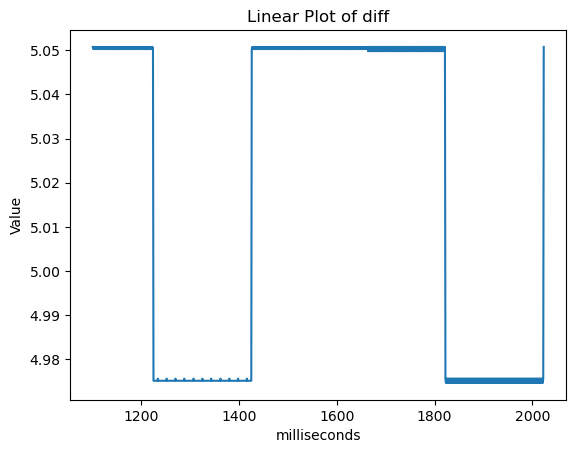

In [13]:
import matplotlib.pyplot as plt

plt.plot(diff[1100:2023])
plt.title('Linear Plot of diff')
plt.xlabel('milliseconds')
plt.ylabel('Value')
plt.show()


In [14]:
seconds_ts.between(seconds_ts.iloc[0], seconds_ts.iloc[-1])

0        True
1        True
2        True
3        True
4        True
         ... 
54088    True
54089    True
54090    True
54091    True
54092    True
Length: 54093, dtype: bool

In [15]:
seconds.shape, accl.shape, gyro.shape

(torch.Size([54093]), torch.Size([3, 54093]), torch.Size([3, 54093]))

### Q1: come si può vedere di seguito, i minuti sono 4, ma in realtà la clip dura 02.23-00.54. Bisogna trimmare l'IMU? 

In [16]:
df.iloc[0, :]

participant_id                          P01
video_id                            P01_102
narration_timestamp            00:00:01.100
start_timestamp                 00:00:00.54
stop_timestamp                  00:00:02.23
start_frame                              27
stop_frame                              111
narration              take knife and plate
verb                                   take
verb_class                                0
noun                                  knife
noun_class                                4
all_nouns                    [knife, plate]
all_noun_classes                     [4, 2]
Name: 0, dtype: object

In [17]:
duration = seconds[-1] - seconds[0]
(duration / 1000.0)/60.0

tensor(4.5332)

# Data Cleaning
Come abbiamo visto nel plot precedente, non tutti i timestamp seguono lo stesso sampling rate. Quindi, per uniformarli, occorre fare un preprocessing. Iniziamo con l'interpolazione.

In [18]:
from scipy.interpolate import interp1d

In [19]:
df.loc[0, 'narration_timestamp'], df.loc[0, 'stop_timestamp']

('00:00:01.100', '00:00:02.23')

In [20]:
def datetime_to_milliseconds(timestamp: str):
    time = timestamp.split(':')
    seconds, micro = time[2].split('.')
    hours = int(time[0])
    minutes = int(time[1])
    return (hours * 3600 + minutes * 60 + int(seconds)) * 1000 + int(micro)

In [21]:
resampling_rate = 200
start_timestamp = datetime_to_milliseconds(df.loc[0, 'narration_timestamp'])
stop_timestamp = datetime_to_milliseconds(df.loc[0, 'stop_timestamp'])
print(start_timestamp, stop_timestamp)


1100 2023


In [22]:
action_idx = ((seconds >= start_timestamp) & (seconds <= stop_timestamp)).nonzero().flatten()
action_ms, action_amplitudes = seconds[action_idx], accl[:, action_idx]
action_ms.shape, action_amplitudes.shape

(torch.Size([188]), torch.Size([3, 188]))

In [23]:
secs = action_ms / 1000.0
target_time_s = torch.linspace(
    secs[0],
    secs[-1],
    steps=int(torch.round((secs[-1] - secs[0]) * resampling_rate))
    )
interpolate_accl_x = interp1d(secs, action_amplitudes[0], kind='linear', axis=0)

In [24]:
accl_x_interp = interpolate_accl_x(target_time_s)

In [25]:
target_time_s.shape, accl_x_interp.shape

(torch.Size([183]), (183,))

In [26]:
diff_interp_accl_x = pd.Series(secs.numpy()).diff()[1:]
diff_interp_accl_x

1      0.004902
2      0.004902
3      0.004902
4      0.004902
5      0.004902
         ...   
183    0.004902
184    0.005050
185    0.005050
186    0.005051
187    0.005050
Length: 187, dtype: float32

In [27]:
mean, median, max_min = diff_interp_accl_x.mean(), diff_interp_accl_x.median(), (diff_interp_accl_x.max(), diff_interp_accl_x.min())
print(f'mean: {mean}\nmedian: {median}\nmax_min: {max_min}')

mean: 0.004905137699097395
median: 0.004902005195617676
max_min: (0.0050506591796875, 0.004901766777038574)


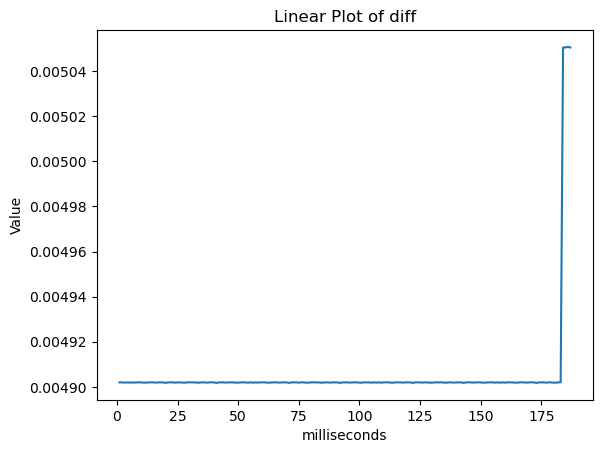

In [28]:
plt.plot(diff_interp_accl_x)
plt.title('Linear Plot of diff')
plt.xlabel('milliseconds')
plt.ylabel('Value')
plt.show()


In [29]:
def plot_signal(time, signal, title):
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

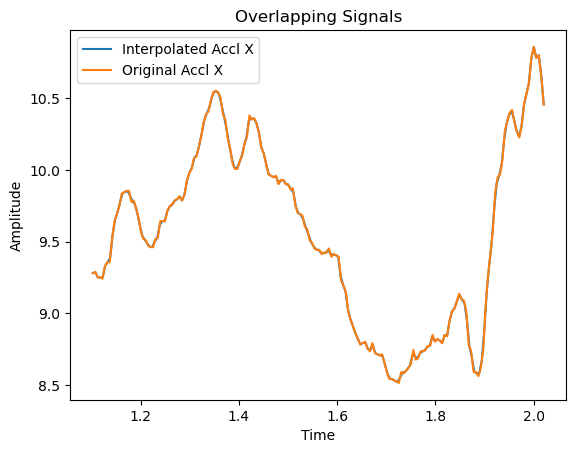

In [30]:
import matplotlib.pyplot as plt

# Plotting the first signal
plt.plot(target_time_s, accl_x_interp, label='Interpolated Accl X')

# Plotting the second signal
plt.plot(action_ms / 1000.0, action_amplitudes[0].numpy(), label='Original Accl X')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Overlapping Signals')

# Add legend
plt.legend()

# Show the plot
plt.show()


# Spectrogram

### TODO: calcolare (\# frequency bins, \# frames) in maniera adattiva

### Q2: Come comportarsi col tempo?
Non tutte le azioni hanno la stessa durata, e la dimensione dello spettrogramma dipendono dai parametri sopra. Questo implica che renderlo quadrato per il ViT è da studiare, perché si intacca la dimensione temporale e può portare a dei bias nel modello.

In [31]:
downsampling_rate = 160

win_length = None
hop_length = 16
# n_fft = int(downsampling_rate * (win_length / 1000) / 2 + 1)
n_fft = 128
TIME_CUT = 30 #30

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True
)

mel_spectrogram = T.MelSpectrogram(
    n_mels=10,
    sample_rate=downsampling_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True,
    f_min=0,
    f_max=80
)


In [32]:
signal = torch.tensor(accl_x_interp, dtype=torch.float32)

In [33]:
def normalize_tensor(tensor):
    tensor = torch.from_numpy(tensor)
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)
    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    return normalized_tensor

def cut_and_pad(signal, sampling_rate, seconds):
    padded_signal = torch.zeros(sampling_rate * seconds)
    if signal.shape[0] < sampling_rate * seconds:
        padded_signal = torch.zeros(sampling_rate * seconds)
        padded_signal[:signal.shape[0]] = signal
    else:
        padded_signal = signal[:sampling_rate * seconds]

    return padded_signal

In [34]:
b, a = sp.signal.iirfilter(4, Wn=5.0, fs=downsampling_rate, btype="low", ftype="butter")
mel_spectrogram.double()
spectrogram.double()

Spectrogram()

In [35]:
filtered_left = sp.signal.lfilter(b, a, torch.abs(signal))
filtered_left = normalize_tensor(filtered_left)
filtered_left = cut_and_pad(filtered_left, downsampling_rate, TIME_CUT)
#filtered_left = mel_spectrogram(torch.from_numpy(filtered_left.numpy()))

In [36]:
filtered_left.shape

torch.Size([4800])

In [37]:
accl_spectrogram = spectrogram(filtered_left)
accl_spectrogram.shape

torch.Size([65, 301])

In [38]:
filtered_left.max(), filtered_left.mean()

(tensor(1.), tensor(0.0313))

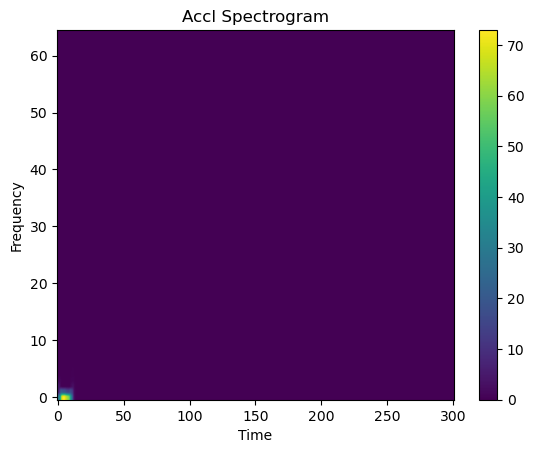

In [39]:
import matplotlib.pyplot as plt

plt.imshow(accl_spectrogram, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Accl Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


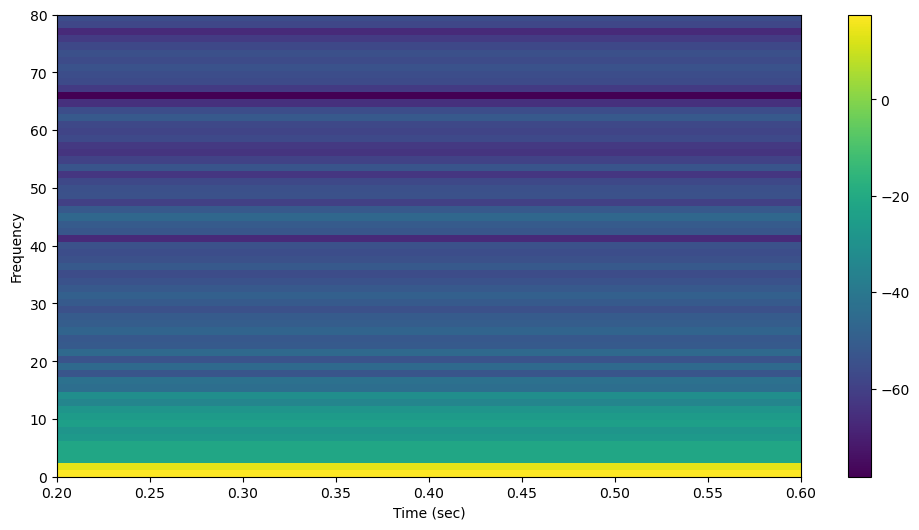

In [40]:
plt.subplots(1,1, figsize=(12,6))
NFFT=128
noverlap = int(0.50*NFFT)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(signal, Fs=downsampling_rate, NFFT=NFFT, noverlap=noverlap, window=np.kaiser(NFFT,5),cmap='viridis')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()